# Przygotowanie skryptu

## Instalacja potrzebnych pakietów
UWAGA: Zainstaluje potrzebne moduły

In [1]:
!pip install numpy matplotlib tensorflow keras pydot graphviz

## Import potrzebnych modułów

In [2]:
import os
import requests
import tarfile
import pickle
import time
import datetime
import matplotlib.pyplot as plt
import numpy as np
import random

from keras import models, layers, activations, losses, optimizers, metrics, callbacks, initializers, backend
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model, to_categorical
from math import floor

## Ustawienie nazw folderów

In [3]:
nazwaFolderuDane = 'dane'
archiwumCifar10 = 'cifar-10.tar.gz'
wnetrzeArchiwum = 'cifar-10-batches-py'
logiUczeniaMaszynowego = 'dzienniki'

rozmiarGrupy = 32

## Pobranie ścieżek do folderów

In [4]:
glownyFolder = os.getcwd()

folderDane = os.path.join(glownyFolder, nazwaFolderuDane)
if not os.path.exists(folderDane):
    os.mkdir(folderDane)

archiwumDoPobrania = os.path.join(folderDane, archiwumCifar10)
pobraneArchiwum = os.path.join(folderDane, wnetrzeArchiwum)

folderLogi = os.path.join(glownyFolder, logiUczeniaMaszynowego)
if not os.path.exists(folderLogi):
    os.mkdir(folderLogi)

In [5]:
data_batch_I = os.path.join(pobraneArchiwum, 'data_batch_')

test_batch = os.path.join(pobraneArchiwum, 'test_batch')

# Przygotowanie danych

## Pobranie zestawu danych
https://www.cs.toronto.edu/~kriz/cifar.html

In [6]:
def pobierzPlikZURL(url, docelowyPlik, chunk_size=128):
    r = requests.get(url)
    with open(docelowyPlik, 'wb') as plik:
        for chunk in r.iter_content(chunk_size=chunk_size):
            plik.write(chunk)

In [7]:
url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
pobierzPlikZURL(url, archiwumDoPobrania)

## Rozpakowanie zestawu danych

In [8]:
tar = tarfile.open(archiwumDoPobrania)
tar.extractall(folderDane)
tar.close()

## Usunięcie archiwum

In [9]:
os.remove(archiwumDoPobrania)

# Rozdzielenie danych

## Funkcja dekodująca plik

In [10]:
def unpickle(plik):
    with open(plik, 'rb') as f:
        slownik = pickle.load(f, encoding='latin1')
    return slownik

## Załadowanie zdjęć i etykiet treningowe
Pliki oznaczone jako data_batch_1 - data_batch_4 zostną załadowane jako dane treningowe. Wartości pixeli są zapisane pod kluczem data, a etykiety jako klucz labels.

In [11]:
zdjeciaTreningowe = np.zeros(shape=(0, 3072))
etykietyTreningowe = []
for i in range(1, 5):
    d = unpickle(data_batch_I + str(i))
    zdjeciaTreningowe = np.concatenate((zdjeciaTreningowe, d['data']))
    etykietyTreningowe += d['labels']
kategorieTreningowe = to_categorical(etykietyTreningowe)
print('Rozmiar danych treningowych: {}\nRozmiar etykiet: {}'.format(zdjeciaTreningowe.shape, len(etykietyTreningowe)))

Rozmiar danych treningowych: (40000, 3072)
Rozmiar etykiet: 40000


## Załadowanie zdjęć i etykiet walidacyjnych
Plik oznaczony jako data_batch_5 zostną załadowane jako dane walidacyjne. Wartości pixeli są zapisane pod kluczem data, a etykiety jako klucz labels.

In [12]:
d = unpickle(data_batch_I + '5')

zdjeciaWalidacyjne = d['data']
etykietyWalidacyjne = d['labels']
kategorieWalidacyjne = to_categorical(etykietyWalidacyjne)

print('Rozmiar danych walidacyjncy: {}\nRozmiar etykiet: {}'.format(zdjeciaWalidacyjne.shape, len(etykietyWalidacyjne)))

Rozmiar danych walidacyjncy: (10000, 3072)
Rozmiar etykiet: 10000


## Załadowanie zdjęć i etykiet testowych
Plik test_batch jako dane testowe. Wartości pixeli są zapisane pod kluczem data, a etykiety jako klucz labels.

In [13]:
d = unpickle(test_batch)
zdjeciaTestowe = d['data']
etykietyTestowe = d['labels']
kategorieTestowe = to_categorical(etykietyTestowe)

print('Rozmiar danych testowych: {}\nRozmiar etykiet: {}'.format(zdjeciaTestowe.shape, len(etykietyTestowe)))

Rozmiar danych testowych: (10000, 3072)
Rozmiar etykiet: 10000


## Funkcja normująca dane
Funkcja zamieni każde pojedyncze zdjecie zapisane jako 1 ciąg pixeli na macierz trójwymiarową (wysokość, szerokość, kanałKoloru). Początkowo są one kodowane w tablicy jednowymiarowej, gdzie najpierw podano wartości 1024 pixeli w kanale czerwonym, następnie w kanale zielonym i na koniec kanał niebieski

In [14]:
def zamienTabliceJednowymiarowaNaTabliceObrazow(tablica):
    return tablica.reshape(tablica.shape[0], 3, 32, 32).transpose(0, 2, 3, 1).astype('uint32')

## Obróbka danych treningowych

In [15]:
zdjeciaTreningowe = zamienTabliceJednowymiarowaNaTabliceObrazow(zdjeciaTreningowe)
print('Rozmiar danych treningowych: {}'.format(zdjeciaTreningowe.shape))

Rozmiar danych treningowych: (40000, 32, 32, 3)


## Obróbka danych walidacyjnych

In [16]:
zdjeciaWalidacyjne = zamienTabliceJednowymiarowaNaTabliceObrazow(zdjeciaWalidacyjne)
print('Rozmiar danych walidacjnych: {}'.format(zdjeciaWalidacyjne.shape))

Rozmiar danych walidacjnych: (10000, 32, 32, 3)


## Obróbka danych testowych

In [17]:
zdjeciaTestowe = zamienTabliceJednowymiarowaNaTabliceObrazow(zdjeciaTestowe)
print('Rozmiar danych testowych: {}'.format(zdjeciaTestowe.shape))

Rozmiar danych testowych: (10000, 32, 32, 3)


## Przygotowanie nazw etykiet
Każda etykieta liczbowa posiada własne dopasowanie słowne.

In [18]:
nazwy_klas = {
    0:'samolot',
    1:'samochód',
    2:'ptak',
    3:'kot',
    4:'jeleń',
    5:'pies',
    6:'żaba',
    7:'koń',
    8:'statek',
    9:'ciężarówka',
}

## Wyświetlenie losowych zdjęć
Wyświetlenie 25 losowych zdjęć z odpowiednią etykietą

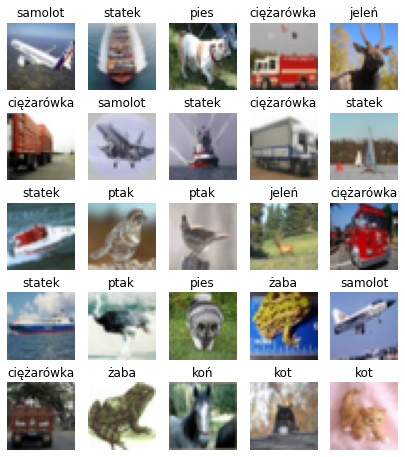

In [19]:
iloscZdjecWLiniWykresu = 5

(_, osi) = plt.subplots(iloscZdjecWLiniWykresu, iloscZdjecWLiniWykresu, figsize=(7, 8))
for i in range(iloscZdjecWLiniWykresu):
    for j in range(iloscZdjecWLiniWykresu):
        x = np.random.choice(range(len(zdjeciaTreningowe)))
        osi[i, j].set_axis_off()
        osi[i, j].imshow(zdjeciaTreningowe[x:x+1][0])
        osi[i, j].set_title(nazwy_klas[etykietyTreningowe[x]])

## Dogenerowanie danych treningowych
Ustawienie generatora zdję zwiększającego ilość próbek którymi się sieć będzie uczyć. Przeszkłceniom będą podlegać istniejące obrazy. Zostaną wykonane losowe przekształcenia takie jak obrót zdjęcia, jego przycinanie. Zdjęcie może także zostać w niewielkim stopniu powiększone, lub odbite w poziomej płaszczyżnie, ale nie w pionowej, gdyż mogłbo by pogorszyć jakość wykrywania nowych obiektów. Obrazy dostępne w zestawie Cifar10 są dosyć niewielkie (32x32 pixele) i duże losowe przeształcenia mogą całkowicie uniemożliwić uczenie. Przez to ustawione parametry przształeń są bardzo małe.

In [20]:
generatorZdjecTreningowych = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 5,
    width_shift_range=0.01,
    height_shift_range=0.01,
    shear_range=0.01,
    zoom_range=0.01,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
)

trenujZdjeciaTreningowe = generatorZdjecTreningowych.flow(zdjeciaTreningowe, kategorieTreningowe, batch_size=rozmiarGrupy)

## Przygotowanie generatora dla zdjęć walidaycjnych i testowych bez modyfikacji
Aby mieć pewność, że sieć działa poprawnie dla zdjęć nie można modyfikować zdjęć służacych do oceny modelu. Należy je jedynie przekształić, aby były w takim samym formacie co dane treningowe

In [21]:
generatorZdjecWalidacyjnych = ImageDataGenerator(
    rescale = 1./255,
)

trenujZdjeciaWalidacyjne = generatorZdjecWalidacyjnych.flow(zdjeciaWalidacyjne, kategorieWalidacyjne, batch_size=rozmiarGrupy)

generatorZdjecTestowych = ImageDataGenerator(
    rescale = 1./255,
)

trenujZdjeciaTestowe = generatorZdjecTestowych.flow(zdjeciaTestowe, kategorieTestowe, batch_size=rozmiarGrupy)

## Wyświetlenie losowego zdjęcia i kilka jego przeształceń
1 zdjęcie (lewy górny róg), pokazuje orginalne zdjęcia a wszystkie inne to jego przekształcenia

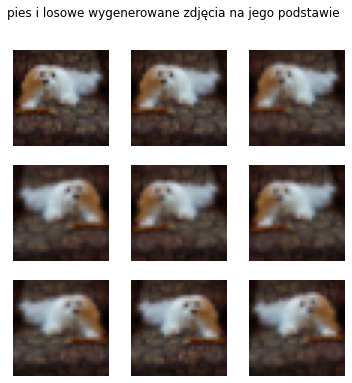

In [22]:
iloscZdjecWLiniWykresuAgmentacja = 3

los = np.random.choice(range(len(zdjeciaTreningowe)))
x = np.array([zdjeciaTreningowe[los]]) / 255

for i in range(1, iloscZdjecWLiniWykresuAgmentacja**2):
    tmp = np.array(generatorZdjecTreningowych.flow(np.array([zdjeciaTreningowe[los]]), batch_size=1)[0])
    x = np.concatenate((x, tmp))

(fig, osi) = plt.subplots(iloscZdjecWLiniWykresuAgmentacja, iloscZdjecWLiniWykresuAgmentacja, figsize=(6, 6))
fig.suptitle('{} i losowe wygenerowane zdjęcia na jego podstawie'.format(nazwy_klas[etykietyTreningowe[los]]))
for i in range(iloscZdjecWLiniWykresuAgmentacja):
    for j in range(iloscZdjecWLiniWykresuAgmentacja):
        osi[i, j].set_axis_off()
        osi[i, j].imshow(x[i * iloscZdjecWLiniWykresuAgmentacja + j])
        if i * j == iloscZdjecWLiniWykresuAgmentacja**2:
            break

# Przygotwnaie TensorBoard
## Funkcja generująca logi podczas trenonowania sieci
TensorBoard to narzędzie do wizualizacji przebiegu trenownia sieci. Podczas trenowania sieci będą zbierane dane zapisywane w plikach, a następnie analizowane w TensorBoard

In [23]:
def zbierajLogi():
    dataUruchomienia = time.strftime("Przebieg %d-%m-%Y %H;%M;%S")
    return os.path.join(folderLogi, dataUruchomienia)

# Utworzenie modelu sieci DNN

In [24]:
modelDNN = models.Sequential(name = "DNN")
modelDNN.add(layer=layers.Flatten(input_shape=[32, 32, 3]))
modelDNN.add(layer=layers.BatchNormalization())
modelDNN.add(layer=layers.Dense(1024, kernel_initializer=initializers.he_normal(), activation=activations.elu, use_bias=False))
modelDNN.add(layer=layers.BatchNormalization())
modelDNN.add(layer=layers.Dense(512, kernel_initializer=initializers.he_normal(), activation=activations.elu, use_bias=False))
modelDNN.add(layer=layers.BatchNormalization())
modelDNN.add(layer=layers.Dense(256, kernel_initializer=initializers.he_normal(), activation=activations.elu, use_bias=False))
modelDNN.add(layer=layers.BatchNormalization())
modelDNN.add(layer=layers.Dense(128, kernel_initializer=initializers.he_normal(), activation=activations.elu, use_bias=False))
modelDNN.add(layer=layers.BatchNormalization())
modelDNN.add(layer=layers.Dense(64, kernel_initializer=initializers.he_normal(), activation=activations.elu, use_bias=False))
modelDNN.add(layer=layers.Dropout(0.2))
modelDNN.add(layer=layers.Dense(10, activation=activations.softmax))

## Sprawdzenie modelu DNN

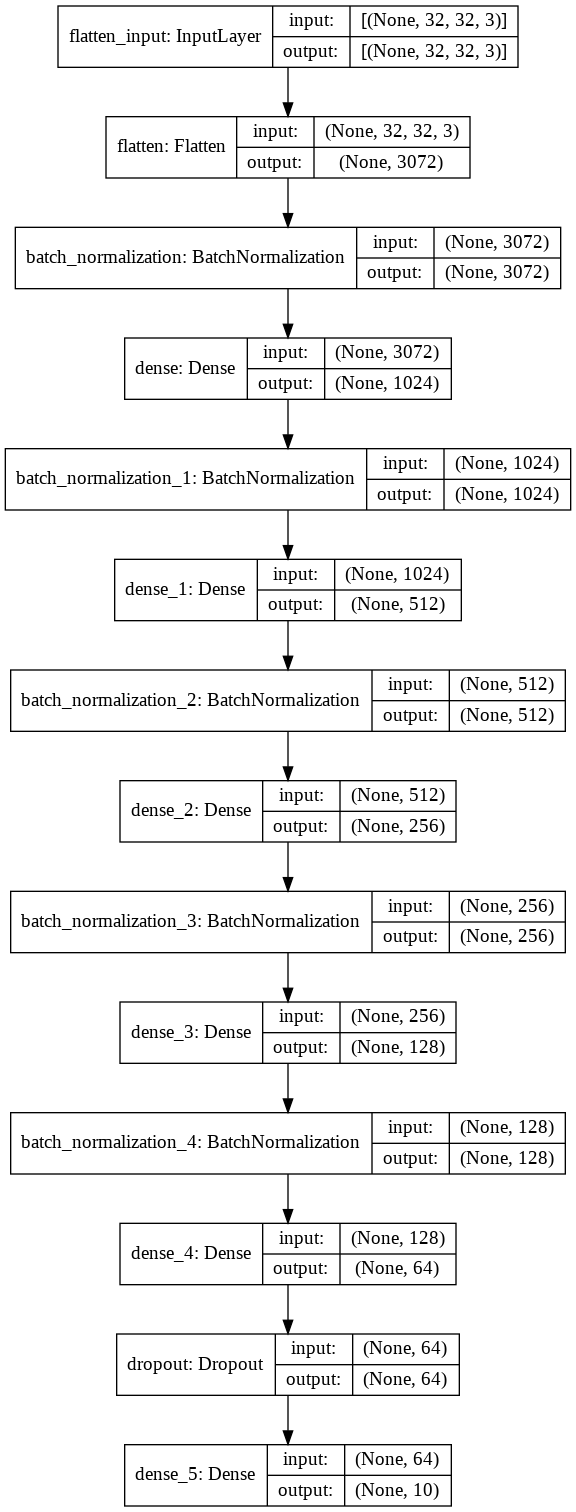

In [25]:
plot_model(modelDNN, show_shapes=True, to_file='modelDNN.png')

In [26]:
modelDNN.summary()

Model: "DNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3072)              12288     
_________________________________________________________________
dense (Dense)                (None, 1024)              3145728   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524288    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131072  

## Kompilacja modelu DNN

In [27]:
modelDNN.compile(
    optimizer=optimizers.RMSprop(learning_rate=10e-4),
    loss=losses.categorical_crossentropy,
    metrics=metrics.categorical_accuracy
)

## Trening modelu DNN

In [28]:
startTreningu = datetime.datetime.now()

przebiegDNN = modelDNN.fit(trenujZdjeciaTreningowe,
                           steps_per_epoch=len(zdjeciaTreningowe) / rozmiarGrupy,
                           epochs=100,
                           validation_data=trenujZdjeciaWalidacyjne,
                           validation_steps=len(zdjeciaWalidacyjne) / rozmiarGrupy,
                           callbacks=[
                               callbacks.TensorBoard(zbierajLogi()),
                               callbacks.EarlyStopping(patience=10, restore_best_weights=True)
                           ]
                          )

koniecTreningu = datetime.datetime.now()
print("Czas trenowania: {}".format(koniecTreningu - startTreningu))

Epoch 1/100
1250/1250 [==============================] - 27s 20ms/step - loss: 2.0034 - categorical_accuracy: 0.3116 - val_loss: 1.5559 - val_categorical_accuracy: 0.4389
Epoch 2/100
1250/1250 [==============================] - 25s 20ms/step - loss: 1.5944 - categorical_accuracy: 0.4360 - val_loss: 1.4509 - val_categorical_accuracy: 0.4900
Epoch 3/100
1250/1250 [==============================] - 25s 20ms/step - loss: 1.4806 - categorical_accuracy: 0.4748 - val_loss: 1.4068 - val_categorical_accuracy: 0.5019
Epoch 4/100
1250/1250 [==============================] - 25s 20ms/step - loss: 1.4153 - categorical_accuracy: 0.5004 - val_loss: 1.3349 - val_categorical_accuracy: 0.5254
Epoch 5/100
1250/1250 [==============================] - 25s 20ms/step - loss: 1.3603 - categorical_accuracy: 0.5207 - val_loss: 1.3006 - val_categorical_accuracy: 0.5428
Epoch 6/100
1250/1250 [==============================] - 25s 20ms/step - loss: 1.3172 - categorical_accuracy: 0.5319 - val_loss: 1.2879 - val_cat

# Utworzenie modelu CNN


In [29]:
modelCNN = models.Sequential(name = "CNN")
modelCNN.add(layer=layers.BatchNormalization(input_shape=(32, 32, 3)))
modelCNN.add(layer=layers.Conv2D(128, kernel_size=(5, 5), padding='same', kernel_initializer=initializers.he_normal(), activation=activations.elu, use_bias=False))
modelCNN.add(layer=layers.BatchNormalization())
modelCNN.add(layer=layers.Conv2D(128, kernel_size=(5, 5), padding='same', kernel_initializer=initializers.he_normal(), activation=activations.elu, use_bias=False))
modelCNN.add(layer=layers.MaxPool2D((2, 2)))
modelCNN.add(layer=layers.BatchNormalization())
modelCNN.add(layer=layers.Conv2D(64, kernel_size=(5, 5), padding='same', kernel_initializer=initializers.he_normal(), activation=activations.elu, use_bias=False))
modelCNN.add(layer=layers.BatchNormalization())
modelCNN.add(layer=layers.Conv2D(64, kernel_size=(5, 5), padding='same', kernel_initializer=initializers.he_normal(), activation=activations.elu, use_bias=False))
modelCNN.add(layer=layers.MaxPool2D((2, 2)))
modelCNN.add(layer=layers.BatchNormalization())
modelCNN.add(layer=layers.Conv2D(32, kernel_size=(5, 5), padding='same', kernel_initializer=initializers.he_normal(), activation=activations.elu, use_bias=False))
modelCNN.add(layer=layers.BatchNormalization())
modelCNN.add(layer=layers.Conv2D(32, kernel_size=(5, 5), padding='same', kernel_initializer=initializers.he_normal(), activation=activations.elu, use_bias=False))
modelCNN.add(layer=layers.MaxPool2D((2, 2)))
modelCNN.add(layer=layers.BatchNormalization())
modelCNN.add(layer=layers.Conv2D(16, kernel_size=(3, 3), padding='same', kernel_initializer=initializers.he_normal(), activation=activations.elu, use_bias=False))
modelCNN.add(layer=layers.BatchNormalization())
modelCNN.add(layer=layers.Conv2D(16, kernel_size=(3, 3), padding='same', kernel_initializer=initializers.he_normal(), activation=activations.elu, use_bias=False))
modelCNN.add(layer=layers.Flatten())
modelCNN.add(layer=layers.Dense(32, kernel_initializer=initializers.he_normal(), activation=activations.elu))
modelCNN.add(layer=layers.Dropout(0.15))
modelCNN.add(layer=layers.Dense(16, kernel_initializer=initializers.he_normal(), activation=activations.elu))
modelCNN.add(layer=layers.Dropout(0.05))
modelCNN.add(layer=layers.Dense(10, activation=activations.softmax))

## Sprawdzenie modelu CNN

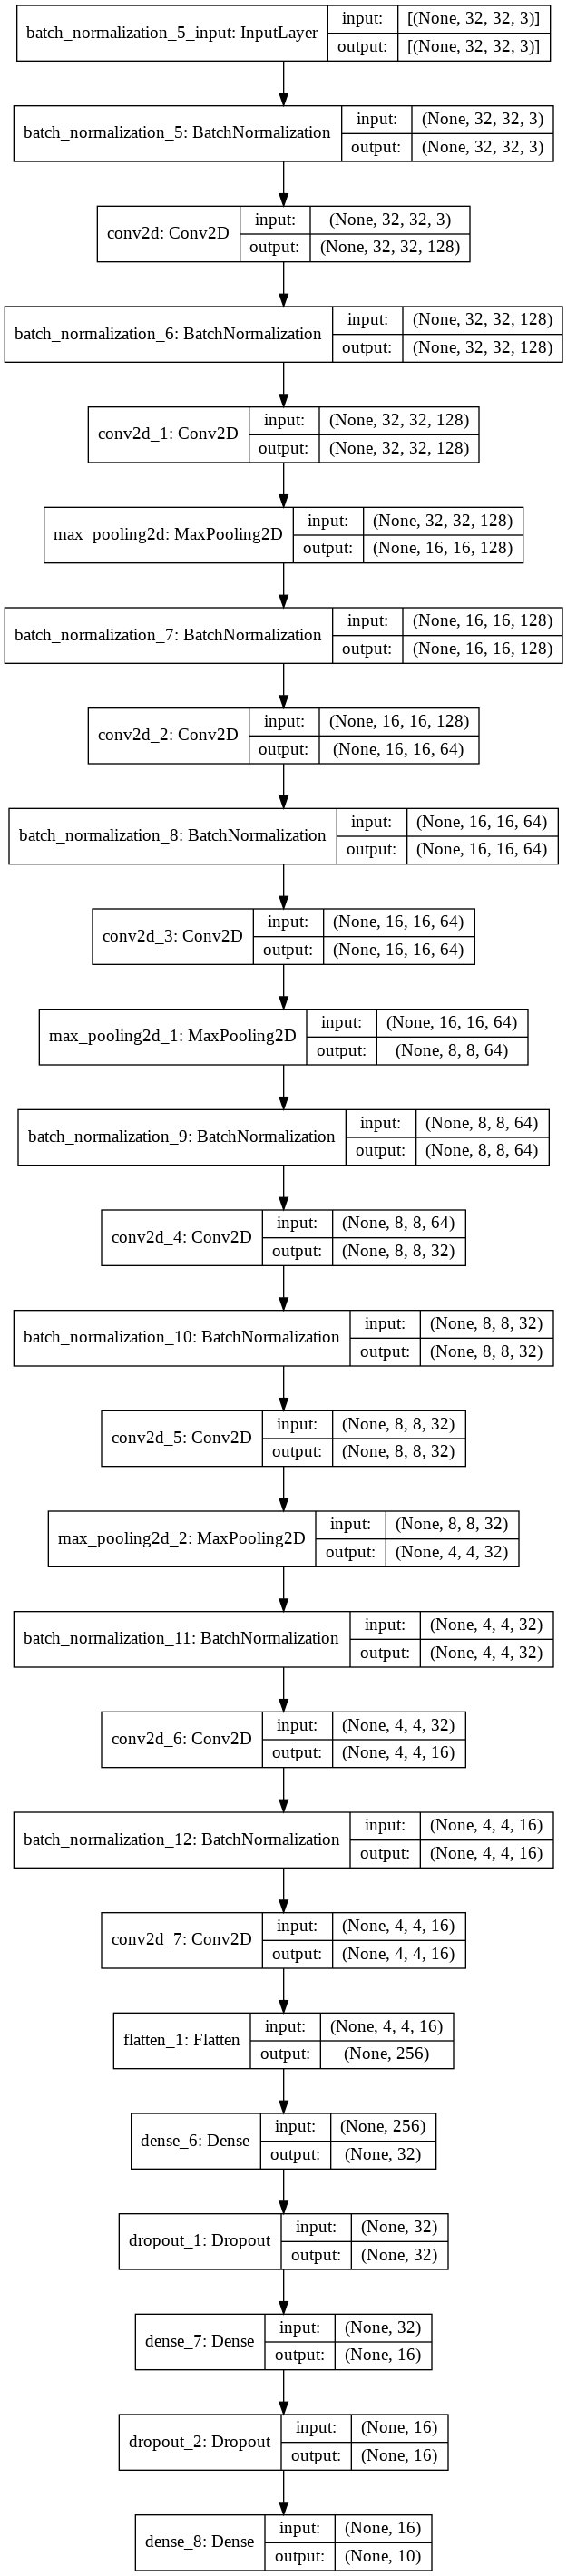

In [30]:
plot_model(modelCNN, show_shapes=True, to_file='modelCNN.png')

In [31]:
modelCNN.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_5 (Batch (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 128)       9600      
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       409600    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        204800  

## Kompilacja modelu CNN

In [32]:
modelCNN.compile(
    optimizer=optimizers.RMSprop(learning_rate=10e-4),
    loss=losses.categorical_crossentropy,
    metrics=metrics.categorical_accuracy
)

## Trening modelu CNN

In [33]:
startTreninguCNN = datetime.datetime.now()

przebiegCNN = modelCNN.fit(trenujZdjeciaTreningowe,
                           steps_per_epoch=len(zdjeciaTreningowe) / rozmiarGrupy,
                           epochs=100,
                           validation_data=trenujZdjeciaWalidacyjne,
                           validation_steps=len(zdjeciaWalidacyjne) / rozmiarGrupy,
                           callbacks=[
                               callbacks.TensorBoard(zbierajLogi()),
                               callbacks.EarlyStopping(patience=10, restore_best_weights=True)
                           ]
                          )

koniecTreninguCNN = datetime.datetime.now()
print("Czas trenowania: {}".format(koniecTreninguCNN - startTreninguCNN))

Epoch 1/100
1250/1250 [==============================] - 34s 25ms/step - loss: 1.8310 - categorical_accuracy: 0.3446 - val_loss: 1.1549 - val_categorical_accuracy: 0.5904
Epoch 2/100
1250/1250 [==============================] - 30s 24ms/step - loss: 1.1204 - categorical_accuracy: 0.6078 - val_loss: 0.9078 - val_categorical_accuracy: 0.6804
Epoch 3/100
1250/1250 [==============================] - 31s 25ms/step - loss: 0.8882 - categorical_accuracy: 0.6966 - val_loss: 0.7946 - val_categorical_accuracy: 0.7295
Epoch 4/100
1250/1250 [==============================] - 30s 24ms/step - loss: 0.7704 - categorical_accuracy: 0.7380 - val_loss: 0.7102 - val_categorical_accuracy: 0.7556
Epoch 5/100
1250/1250 [==============================] - 30s 24ms/step - loss: 0.6921 - categorical_accuracy: 0.7668 - val_loss: 0.7557 - val_categorical_accuracy: 0.7522
Epoch 6/100
1250/1250 [==============================] - 30s 24ms/step - loss: 0.6296 - categorical_accuracy: 0.7901 - val_loss: 0.6265 - val_cat

# Testy
## Testowanie modelu DNN

In [34]:
bladTestu, dokladnoscTestu = modelDNN.evaluate(trenujZdjeciaTestowe)

print('Błąd modelu DNN: {}\nDokładność modelu DNN: {}'.format(bladTestu, dokladnoscTestu))

313/313 [==============================] - 1s 3ms/step - loss: 1.2100 - categorical_accuracy: 0.5853
Błąd modelu DNN: 1.2100341320037842
Dokładność modelu DNN: 0.5853000283241272


## Testowanie modelu CNN

In [35]:
bladTestuCNN, dokladnoscTestuCNN = modelCNN.evaluate(trenujZdjeciaTestowe)

print('Błąd modelu CNN: {}\nDokładność modelu CNN: {}'.format(bladTestuCNN, dokladnoscTestuCNN))

313/313 [==============================] - 2s 6ms/step - loss: 0.5507 - categorical_accuracy: 0.8314
Błąd modelu CNN: 0.5506994724273682
Dokładność modelu CNN: 0.8313999772071838


# Wykresy

## Przebieg uczenia modelu DNN

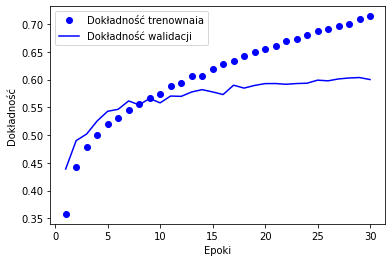

In [36]:
acc = przebiegDNN.history['categorical_accuracy']
val_acc = przebiegDNN.history['val_categorical_accuracy']
epoki = range(1, len(acc) + 1)

plt.plot(epoki, acc, 'bo', label = 'Dokładność trenownaia')
plt.plot(epoki, val_acc, 'b-', label = 'Dokładność walidacji')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend()
plt.show()

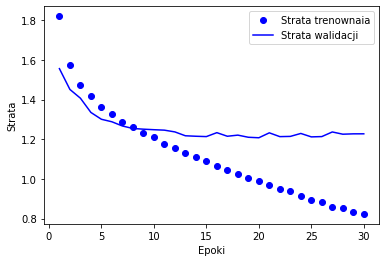

In [37]:
loss = przebiegDNN.history['loss']
val_loss = przebiegDNN.history['val_loss']
epoki = range(1, len(loss) + 1)

plt.plot(epoki, loss, 'bo', label = 'Strata trenownaia')
plt.plot(epoki, val_loss, 'b-', label = 'Strata walidacji')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()

## Przebieg uczenia CNN

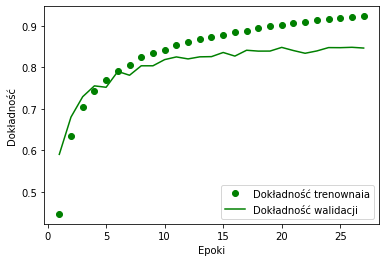

In [38]:
acc = przebiegCNN.history['categorical_accuracy']
valAcc = przebiegCNN.history['val_categorical_accuracy']
epoki = range(1, len(acc) + 1)

plt.plot(epoki, acc, 'go', label = 'Dokładność trenownaia')
plt.plot(epoki, valAcc, 'g-', label = 'Dokładność walidacji')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend()
plt.show()

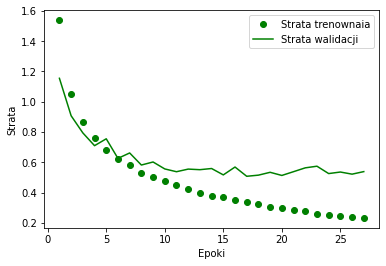

In [39]:
loss = przebiegCNN.history['loss']
valLoss = przebiegCNN.history['val_loss']
epoki = range(1, len(loss) + 1)

plt.plot(epoki, loss, 'go', label = 'Strata trenownaia')
plt.plot(epoki, valLoss, 'g-', label = 'Strata walidacji')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()

## Porównie dokładności modeli

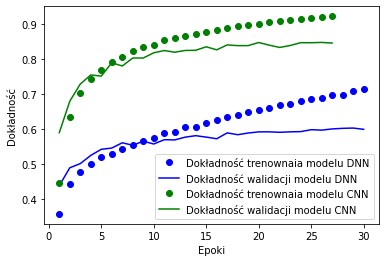

In [40]:
accDNN = przebiegDNN.history['categorical_accuracy']
valAccDNN = przebiegDNN.history['val_categorical_accuracy']
epokiDNN = range(1, len(accDNN) + 1)

accCNN = przebiegCNN.history['categorical_accuracy']
valAccCNN = przebiegCNN.history['val_categorical_accuracy']
epokiCNN = range(1, len(accCNN) + 1)

plt.plot(epokiDNN, accDNN, 'bo', label = 'Dokładność trenownaia modelu DNN')
plt.plot(epokiDNN, valAccDNN, 'b-', label = 'Dokładność walidacji modelu DNN')
plt.plot(epokiCNN, accCNN, 'go', label = 'Dokładność trenownaia modelu CNN')
plt.plot(epokiCNN, valAccCNN, 'g-', label = 'Dokładność walidacji modelu CNN')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend()
plt.show()

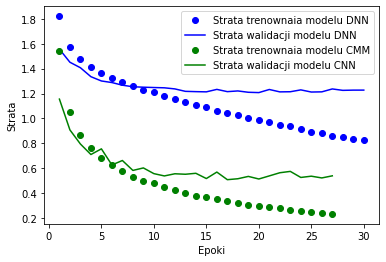

In [41]:
lossDNN = przebiegDNN.history['loss']
valLossDNN = przebiegDNN.history['val_loss']
epokiDNN = range(1, len(lossDNN) + 1)

lossCNN = przebiegCNN.history['loss']
valLossCNN = przebiegCNN.history['val_loss']
epokiCNN = range(1, len(lossCNN) + 1)

plt.plot(epokiDNN, lossDNN, 'bo', label = 'Strata trenownaia modelu DNN')
plt.plot(epokiDNN, valLossDNN, 'b-', label = 'Strata walidacji modelu DNN')
plt.plot(epoki, lossCNN, 'go', label = 'Strata trenownaia modelu CMM')
plt.plot(epoki, valLossCNN, 'g-', label = 'Strata walidacji modelu CNN')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()

# Wyświetelnie próbek wyniku
Zostnie wyświetlone 25 losowych próbek, wylosowanych wcześniej. Dodatkowo zostanie wyświetlona proponowna klasa przez model wraz z prawdopodobieństwem wyliczonym przez dany model dla danego zdjęcia



## Przygotowanie próbek do wyświetlenia

In [42]:
def zamienNaProcent(val, digits):
     val *= 10 ** (digits + 2)
     return '{1:.{0}f}'.format(digits, floor(val) / 10 ** digits)

iloscZdjecWLiniWykresu = 5
zdjeciaDoWyswietlenia = random.choices(range(0, len(zdjeciaTestowe)), k = iloscZdjecWLiniWykresu * iloscZdjecWLiniWykresu)
print(zdjeciaDoWyswietlenia)

[6984, 4989, 4845, 9783, 2518, 5553, 7608, 8958, 8909, 3942, 2833, 2100, 8118, 1582, 3553, 4594, 6679, 4681, 8963, 6190, 2577, 9245, 6004, 5163, 5042]


## Funkcja wyświetaljąca wyniki

In [43]:
def wyswietlWyniki(model, probki):
  (_, osi) = plt.subplots(iloscZdjecWLiniWykresu, iloscZdjecWLiniWykresu, figsize=(11, 10))
  for i in range(iloscZdjecWLiniWykresu):
      for j in range(iloscZdjecWLiniWykresu):
          x = probki[i * iloscZdjecWLiniWykresu + j]
          osi[i, j].set_axis_off()
          y = zdjeciaTestowe[x:x+1] / 255.0
          osi[i, j].imshow(y[0])

          przewidywanie = model.predict(y)
          najbardziejPrawdopodobny = np.argmax(przewidywanie)
          osi[i, j].set_title('{} - {}%'.format(nazwy_klas[najbardziejPrawdopodobny], zamienNaProcent(przewidywanie[0][najbardziejPrawdopodobny], 1)))

## Wyświetl przewidywania dla modelu DNN

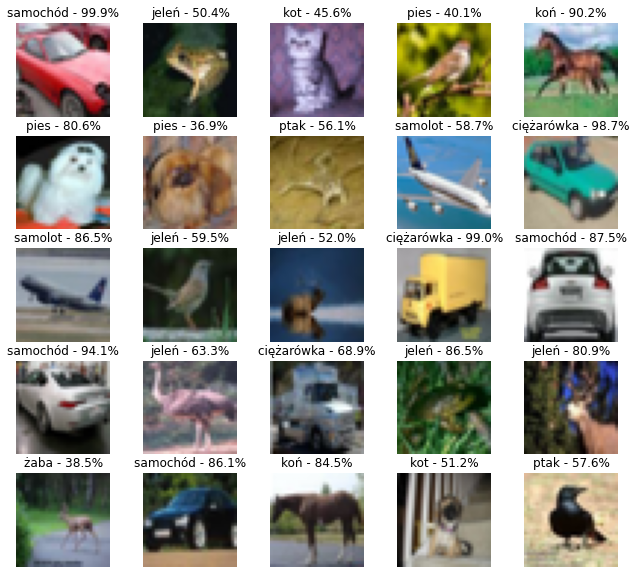

In [44]:
wyswietlWyniki(modelDNN, zdjeciaDoWyswietlenia)

## Wyświetl przewidywania dla modelu CNN

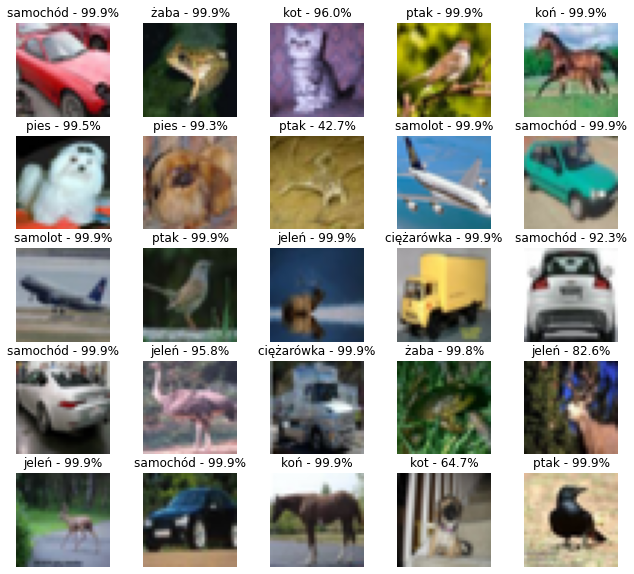

In [45]:
wyswietlWyniki(modelCNN, zdjeciaDoWyswietlenia)